In [1]:
import keras
from keras import layers
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
# 데이터 불러오기 및 정렬
featureData = pd.read_csv('../dataset/feature_regression_example.csv')
sortKey = ["REGIONID","PRODUCTGROUP","PRODUCT","ITEM","YEARWEEK"]
featureData = featureData.sort_values(sortKey)

# 숫자형 컬럼 생성
featureData["HOLIDAY_YN"] = np.where(featureData.HOLIDAY=="Y",1,0)
featureData["PROMOTION_YN"] = np.where(featureData.PROMOTION=="Y",1,0)

In [3]:
featureData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HOLIDAY_YN,PROMOTION_YN
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442,1,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442,0,1
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155,0,1
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155,1,1
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155,0,1


In [4]:
featureData.dtypes

REGIONID         object
PRODUCTGROUP     object
PRODUCT          object
ITEM             object
YEARWEEK          int64
YEAR              int64
WEEK              int64
QTY               int64
HOLIDAY          object
HCLUS             int64
PROMOTION        object
PRO_PERCENT     float64
HOLIDAY_YN        int32
PROMOTION_YN      int32
dtype: object

In [5]:
predictStd = 201630
train_dataset = featureData.query('YEARWEEK <= @predictStd')
test_dataset = featureData.query('YEARWEEK > @predictStd')

train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_labels = train_dataset["QTY"]
test_labels = test_dataset["QTY"]

In [6]:
corr_result = train_dataset.corr()

# 상관관계 계수 비율 선정
featuresStd = 0.6

corr_result

features_key = corr_result[ (abs(corr_result.QTY) >= 0.5) &
                (corr_result.QTY != 1)].index.tolist()
features_key

label_key = ['QTY']

full_key = features_key+label_key

In [7]:
train_stats = train_dataset[features_key].describe()
train_stats

,HCLUS,PRO_PERCENT,HOLIDAY_YN,PROMOTION_YN
count,83.000000,83.000000,83.000000,83.000000
mean,2.819277,0.178241,0.385542,0.722892
std,1.531336,0.118036,0.489682,0.450291
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,4.000000,0.209442,0.000000,1.000000
75%,4.000000,0.237768,1.000000,1.000000
max,4.000000,0.357511,1.000000,1.000000


In [8]:
def norm(x):
  return (x / x.max())
normed_train_data = norm(train_dataset[features_key])
normed_test_data = norm(test_dataset[features_key])

In [9]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=[len(features_key)]),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
  ])

  #optimizer = keras.optimizers.RMSprop(0.001)
  optimizer = keras.optimizers.Adam()
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [10]:
model = build_model()

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [12]:
normed_train_data[:10]

,HCLUS,PRO_PERCENT,HOLIDAY_YN,PROMOTION_YN
0,0.25,0.585834,1.0,1.0
1,1.00,0.585834,0.0,1.0
2,1.00,0.582233,0.0,1.0
3,0.50,0.582233,1.0,1.0
4,1.00,0.582233,0.0,1.0
5,1.00,0.582233,0.0,1.0
6,1.00,0.582233,0.0,1.0
7,0.25,0.582233,1.0,1.0
8,1.00,0.582233,0.0,1.0
9,1.00,0.000000,0.0,0.0


In [14]:
from keras.callbacks import EarlyStopping
#더이상 에러율이 향상되지 않을 시 정지한다, 단 patience 옵션 유지(너무빨리 끝나는거 방지)
early_stopping_monitor = EarlyStopping(patience=50)
EPOCHS = 2000
#모델 훈련 (훈련/검증을 80%, 20%로 나눔)
history =model.fit(normed_train_data, train_labels, validation_split=0.2, epochs= EPOCHS, callbacks=[early_stopping_monitor])

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

Instructions for updating:
Use tf.cast instead.
Train on 66 samples, validate on 17 samples
Epoch 1/2000
66/66 [==============================] - 0s 4ms/step - loss: 1973686.6894 - mean_absolute_error: 1123.1460 - mean_squared_error: 1973686.6894 - val_loss: 1711966.2500 - val_mean_absolute_error: 1085.1418 - val_mean_squared_error: 1711966.2500
Epoch 2/2000
66/66 [==============================] - 0s 106us/step - loss: 1973345.3788 - mean_absolute_error: 1123.0096 - mean_squared_error: 1973345.3788 - val_loss: 1711599.2500 - val_mean_absolute_error: 1084.9866 - val_mean_squared_error: 1711599.2500
Epoch 3/2000
66/66 [==============================] - 0s 91us/step - loss: 1972984.3371 - mean_absolute_error: 1122.8632 - mean_squared_error: 1972984.3371 - val_loss: 1711231.0000 - val_mean_absolute_error: 1084.8329 - val_mean_squared_error: 1711231.0000
Epoch 4/2000
66/66 [==============================] - 0s 106us/step - loss: 1972641.0407 - mean_absolute_error: 1122.7248 - mean_squared_

Epoch 32/2000
66/66 [==============================] - 0s 121us/step - loss: 1933644.9962 - mean_absolute_error: 1107.0915 - mean_squared_error: 1933644.9962 - val_loss: 1667324.7500 - val_mean_absolute_error: 1066.3115 - val_mean_squared_error: 1667324.7500
Epoch 33/2000
66/66 [==============================] - 0s 181us/step - loss: 1929950.9980 - mean_absolute_error: 1105.5927 - mean_squared_error: 1929950.9980 - val_loss: 1663363.2500 - val_mean_absolute_error: 1064.6241 - val_mean_squared_error: 1663363.2500
Epoch 34/2000
66/66 [==============================] - 0s 106us/step - loss: 1925907.4242 - mean_absolute_error: 1104.0246 - mean_squared_error: 1925907.4242 - val_loss: 1659127.3750 - val_mean_absolute_error: 1062.8169 - val_mean_squared_error: 1659127.3750
Epoch 35/2000
66/66 [==============================] - 0s 91us/step - loss: 1921722.3561 - mean_absolute_error: 1102.3161 - mean_squared_error: 1921722.3561 - val_loss: 1654321.6250 - val_mean_absolute_error: 1060.7671 - va

Epoch 64/2000
66/66 [==============================] - 0s 76us/step - loss: 1609972.1667 - mean_absolute_error: 974.8356 - mean_squared_error: 1609972.1667 - val_loss: 1323038.3750 - val_mean_absolute_error: 921.0916 - val_mean_squared_error: 1323038.3750
Epoch 65/2000
66/66 [==============================] - 0s 91us/step - loss: 1592244.6818 - mean_absolute_error: 967.3342 - mean_squared_error: 1592244.6818 - val_loss: 1304992.8750 - val_mean_absolute_error: 913.9249 - val_mean_squared_error: 1304992.8750
Epoch 66/2000
66/66 [==============================] - 0s 76us/step - loss: 1574825.0833 - mean_absolute_error: 959.7128 - mean_squared_error: 1574825.0833 - val_loss: 1285969.8750 - val_mean_absolute_error: 906.3000 - val_mean_squared_error: 1285969.8750
Epoch 67/2000
66/66 [==============================] - 0s 76us/step - loss: 1556656.4766 - mean_absolute_error: 951.4360 - mean_squared_error: 1556656.4766 - val_loss: 1266779.2500 - val_mean_absolute_error: 898.5325 - val_mean_squa

66/66 [==============================] - 0s 106us/step - loss: 944025.9967 - mean_absolute_error: 657.9991 - mean_squared_error: 944025.9967 - val_loss: 666430.6875 - val_mean_absolute_error: 616.7974 - val_mean_squared_error: 666430.6875
Epoch 97/2000
66/66 [==============================] - 0s 76us/step - loss: 926680.8788 - mean_absolute_error: 649.7577 - mean_squared_error: 926680.8788 - val_loss: 649887.6250 - val_mean_absolute_error: 610.4088 - val_mean_squared_error: 649887.6250
Epoch 98/2000
66/66 [==============================] - 0s 121us/step - loss: 906469.0833 - mean_absolute_error: 640.2895 - mean_squared_error: 906469.0833 - val_loss: 630941.7500 - val_mean_absolute_error: 602.8443 - val_mean_squared_error: 630941.7500
Epoch 99/2000
66/66 [==============================] - 0s 76us/step - loss: 887671.9419 - mean_absolute_error: 630.3944 - mean_squared_error: 887671.9419 - val_loss: 611986.5000 - val_mean_absolute_error: 595.0119 - val_mean_squared_error: 611986.5000
Epoc

66/66 [==============================] - 0s 106us/step - loss: 544704.9152 - mean_absolute_error: 489.6041 - mean_squared_error: 544704.9152 - val_loss: 345106.2812 - val_mean_absolute_error: 495.6562 - val_mean_squared_error: 345106.2812
Epoch 129/2000
66/66 [==============================] - 0s 76us/step - loss: 538597.5123 - mean_absolute_error: 489.0839 - mean_squared_error: 538597.5123 - val_loss: 341717.9375 - val_mean_absolute_error: 494.3830 - val_mean_squared_error: 341717.9375
Epoch 130/2000
66/66 [==============================] - 0s 60us/step - loss: 532619.3712 - mean_absolute_error: 488.3562 - mean_squared_error: 532619.3712 - val_loss: 338161.5000 - val_mean_absolute_error: 494.5685 - val_mean_squared_error: 338161.5000
Epoch 131/2000
66/66 [==============================] - 0s 106us/step - loss: 526404.0616 - mean_absolute_error: 487.5755 - mean_squared_error: 526404.0616 - val_loss: 334453.2500 - val_mean_absolute_error: 494.9860 - val_mean_squared_error: 334453.2500
E

66/66 [==============================] - 0s 106us/step - loss: 450375.0218 - mean_absolute_error: 473.1418 - mean_squared_error: 450375.0218 - val_loss: 310109.6250 - val_mean_absolute_error: 497.9656 - val_mean_squared_error: 310109.6250
Epoch 161/2000
66/66 [==============================] - 0s 91us/step - loss: 449336.8762 - mean_absolute_error: 472.5374 - mean_squared_error: 449336.8762 - val_loss: 309277.0000 - val_mean_absolute_error: 497.1999 - val_mean_squared_error: 309277.0000
Epoch 162/2000
66/66 [==============================] - 0s 91us/step - loss: 448432.3712 - mean_absolute_error: 471.8614 - mean_squared_error: 448432.3712 - val_loss: 308638.5938 - val_mean_absolute_error: 496.6577 - val_mean_squared_error: 308638.5938
Epoch 163/2000
66/66 [==============================] - 0s 91us/step - loss: 447412.8497 - mean_absolute_error: 471.3724 - mean_squared_error: 447412.8497 - val_loss: 308166.7188 - val_mean_absolute_error: 496.2925 - val_mean_squared_error: 308166.7188
Ep

66/66 [==============================] - 0s 136us/step - loss: 414378.4607 - mean_absolute_error: 465.7819 - mean_squared_error: 414378.4607 - val_loss: 310160.5000 - val_mean_absolute_error: 493.7456 - val_mean_squared_error: 310160.5000
Epoch 193/2000
66/66 [==============================] - 0s 91us/step - loss: 412835.5152 - mean_absolute_error: 465.5443 - mean_squared_error: 412835.5152 - val_loss: 311149.0938 - val_mean_absolute_error: 494.6165 - val_mean_squared_error: 311149.0938
Epoch 194/2000
66/66 [==============================] - 0s 91us/step - loss: 412151.3523 - mean_absolute_error: 465.7913 - mean_squared_error: 412151.3523 - val_loss: 312718.7188 - val_mean_absolute_error: 496.8891 - val_mean_squared_error: 312718.7188
Epoch 195/2000
66/66 [==============================] - 0s 76us/step - loss: 411227.6165 - mean_absolute_error: 465.7689 - mean_squared_error: 411227.6165 - val_loss: 312733.4062 - val_mean_absolute_error: 497.3407 - val_mean_squared_error: 312733.4062
Ep

66/66 [==============================] - 0s 121us/step - loss: 390633.4527 - mean_absolute_error: 445.5466 - mean_squared_error: 390633.4527 - val_loss: 286742.2188 - val_mean_absolute_error: 473.7912 - val_mean_squared_error: 286742.2188
Epoch 225/2000
66/66 [==============================] - 0s 181us/step - loss: 390205.4557 - mean_absolute_error: 444.5543 - mean_squared_error: 390205.4557 - val_loss: 285246.1875 - val_mean_absolute_error: 472.0366 - val_mean_squared_error: 285246.1875
Epoch 226/2000
66/66 [==============================] - 0s 91us/step - loss: 389793.6297 - mean_absolute_error: 443.6164 - mean_squared_error: 389793.6297 - val_loss: 284487.4688 - val_mean_absolute_error: 471.2596 - val_mean_squared_error: 284487.4688
Epoch 227/2000
66/66 [==============================] - 0s 91us/step - loss: 389193.9936 - mean_absolute_error: 442.9549 - mean_squared_error: 389193.9936 - val_loss: 284530.4062 - val_mean_absolute_error: 471.5667 - val_mean_squared_error: 284530.4062
E

66/66 [==============================] - 0s 106us/step - loss: 372826.9561 - mean_absolute_error: 436.4145 - mean_squared_error: 372826.9561 - val_loss: 288993.0000 - val_mean_absolute_error: 485.2064 - val_mean_squared_error: 288993.0000
Epoch 257/2000
66/66 [==============================] - 0s 76us/step - loss: 372370.7500 - mean_absolute_error: 435.9328 - mean_squared_error: 372370.7500 - val_loss: 288986.8750 - val_mean_absolute_error: 485.4932 - val_mean_squared_error: 288986.8750
Epoch 258/2000
66/66 [==============================] - 0s 151us/step - loss: 371786.4550 - mean_absolute_error: 435.6822 - mean_squared_error: 371786.4550 - val_loss: 290430.5312 - val_mean_absolute_error: 487.7411 - val_mean_squared_error: 290430.5312
Epoch 259/2000
66/66 [==============================] - 0s 91us/step - loss: 371315.0312 - mean_absolute_error: 435.9574 - mean_squared_error: 371315.0312 - val_loss: 290386.1875 - val_mean_absolute_error: 487.9647 - val_mean_squared_error: 290386.1875
E

66/66 [==============================] - 0s 106us/step - loss: 360710.9432 - mean_absolute_error: 424.3120 - mean_squared_error: 360710.9432 - val_loss: 277467.0000 - val_mean_absolute_error: 475.2521 - val_mean_squared_error: 277467.0000
Epoch 289/2000
66/66 [==============================] - 0s 76us/step - loss: 359717.4318 - mean_absolute_error: 424.1608 - mean_squared_error: 359717.4318 - val_loss: 280656.6250 - val_mean_absolute_error: 479.7252 - val_mean_squared_error: 280656.6250
Epoch 290/2000
66/66 [==============================] - 0s 166us/step - loss: 360159.7547 - mean_absolute_error: 425.6835 - mean_squared_error: 360159.7547 - val_loss: 284661.7812 - val_mean_absolute_error: 485.0132 - val_mean_squared_error: 284661.7812
Epoch 291/2000
66/66 [==============================] - 0s 76us/step - loss: 359251.7152 - mean_absolute_error: 425.8551 - mean_squared_error: 359251.7152 - val_loss: 286460.4375 - val_mean_absolute_error: 487.3507 - val_mean_squared_error: 286460.4375
E

66/66 [==============================] - 0s 151us/step - loss: 352371.8139 - mean_absolute_error: 417.7928 - mean_squared_error: 352371.8139 - val_loss: 266141.1875 - val_mean_absolute_error: 462.3546 - val_mean_squared_error: 266141.1875
Epoch 321/2000
66/66 [==============================] - 0s 106us/step - loss: 352095.3827 - mean_absolute_error: 417.7520 - mean_squared_error: 352095.3827 - val_loss: 266314.2500 - val_mean_absolute_error: 462.6384 - val_mean_squared_error: 266314.2500
Epoch 322/2000
66/66 [==============================] - 0s 151us/step - loss: 351904.1970 - mean_absolute_error: 417.7455 - mean_squared_error: 351904.1970 - val_loss: 266642.4062 - val_mean_absolute_error: 463.1316 - val_mean_squared_error: 266642.4062
Epoch 323/2000
66/66 [==============================] - 0s 121us/step - loss: 351717.9607 - mean_absolute_error: 417.7252 - mean_squared_error: 351717.9607 - val_loss: 266767.1250 - val_mean_absolute_error: 463.3397 - val_mean_squared_error: 266767.1250

66/66 [==============================] - 0s 166us/step - loss: 347697.3106 - mean_absolute_error: 415.2273 - mean_squared_error: 347697.3106 - val_loss: 263791.1875 - val_mean_absolute_error: 459.6493 - val_mean_squared_error: 263791.1875
Epoch 353/2000
66/66 [==============================] - 0s 166us/step - loss: 347587.1392 - mean_absolute_error: 414.9077 - mean_squared_error: 347587.1392 - val_loss: 262151.3750 - val_mean_absolute_error: 457.3834 - val_mean_squared_error: 262151.3750
Epoch 354/2000
66/66 [==============================] - 0s 121us/step - loss: 347668.2588 - mean_absolute_error: 414.5864 - mean_squared_error: 347668.2588 - val_loss: 260254.5625 - val_mean_absolute_error: 454.7131 - val_mean_squared_error: 260254.5625
Epoch 355/2000
66/66 [==============================] - 0s 181us/step - loss: 347819.8447 - mean_absolute_error: 414.2168 - mean_squared_error: 347819.8447 - val_loss: 258869.4375 - val_mean_absolute_error: 452.7288 - val_mean_squared_error: 258869.4375

Epoch 384/2000
66/66 [==============================] - 0s 91us/step - loss: 345934.3542 - mean_absolute_error: 419.9073 - mean_squared_error: 345934.3542 - val_loss: 300971.9062 - val_mean_absolute_error: 500.4836 - val_mean_squared_error: 300971.9062
Epoch 385/2000
66/66 [==============================] - 0s 106us/step - loss: 345634.0360 - mean_absolute_error: 419.6992 - mean_squared_error: 345634.0360 - val_loss: 299916.9062 - val_mean_absolute_error: 499.4500 - val_mean_squared_error: 299916.9062
Epoch 386/2000
66/66 [==============================] - 0s 121us/step - loss: 345463.9530 - mean_absolute_error: 419.4344 - mean_squared_error: 345463.9530 - val_loss: 298773.6250 - val_mean_absolute_error: 498.3010 - val_mean_squared_error: 298773.6250
Epoch 387/2000
66/66 [==============================] - ETA: 0s - loss: 288693.0938 - mean_absolute_error: 414.6511 - mean_squared_error: 288693.09 - 0s 76us/step - loss: 345335.7094 - mean_absolute_error: 419.1620 - mean_squared_error: 34

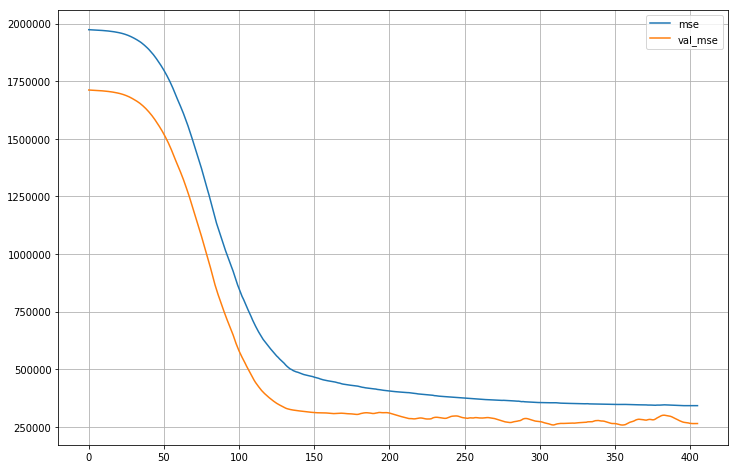

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.legend(['mse','val_mse'])
plt.grid()
plt.show()

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

In [18]:
mae

480.08251953125

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
401,264863.31250,459.900635,264863.31250,342544.070460,412.790278,342544.070460,401
402,264614.62500,459.584076,264614.62500,342526.456676,412.654612,342526.456676,402
403,264792.59375,459.807068,264792.59375,342480.222538,412.631399,342480.222538,403
404,265177.93750,460.285034,265177.93750,342484.616951,412.669456,342484.616951,404
405,264811.87500,459.795776,264811.87500,342421.481534,412.690850,342421.481534,405


In [20]:
# 예측 수행
test_predictions = model.predict(normed_test_data).flatten()
test_predictions

# 예측결과 별도 데이터프레임 생성
predictValues = pd.DataFrame(list(test_predictions), columns = ["PREDICT"])

# 예측결과 컬럼 생성
finalResult = pd.concat([test_dataset,predictValues],axis=1)
finalResult

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HOLIDAY_YN,PROMOTION_YN,PREDICT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0,1,1174.014526
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0,1,1174.014526
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0,0,345.783569
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1,1,1761.839111
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1,1,1761.839111
5,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201636,2016,36,1501,Y,1,Y,0.308584,1,1,1761.839111
6,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201637,2016,37,1491,N,4,Y,0.308584,0,1,1209.570801
7,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201638,2016,38,806,N,4,Y,0.308584,0,1,1209.570801
8,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201639,2016,39,2111,N,4,Y,0.280258,0,1,1174.014526
9,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201640,2016,40,2400,N,4,Y,0.280258,0,1,1174.014526


In [21]:
finalResult = finalResult[finalResult.YEARWEEK <= 201652]

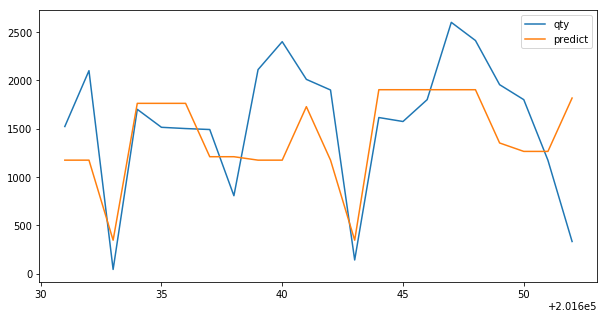

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,5))
plt.plot(finalResult["YEARWEEK"], finalResult.QTY, label = "qty")
plt.plot(finalResult["YEARWEEK"], finalResult.PREDICT, label = "predict")
plt.legend(loc=0)